# ANN_2

이정재  
2024-01-29

# `Step 1` : Load libraries & Datasts

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# FashionMNIST 데이터 불러오기
training_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

In [3]:
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

# `Step 2` : Create DataLoader

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [5]:
# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

device = cuda

# EDA

In [6]:
print(training_data, '\n--------------------------\n', test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() 
--------------------------
 Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])

In [8]:
len(training_data)

label=9

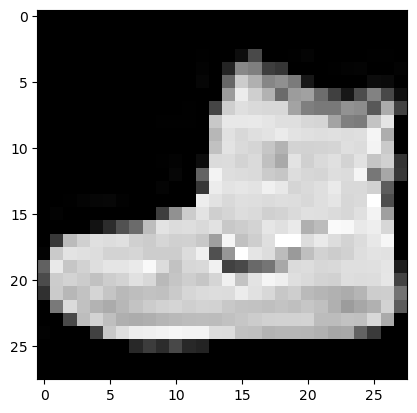

In [9]:
img, label = training_data[0]
plt.imshow(img.squeeze(), cmap='gray')
print(f'label={label}')

In [10]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Bag
Bag
Trouser
Ankle Boot
Sneaker
Coat
Coat
Bag
Ankle Boot
Shirt

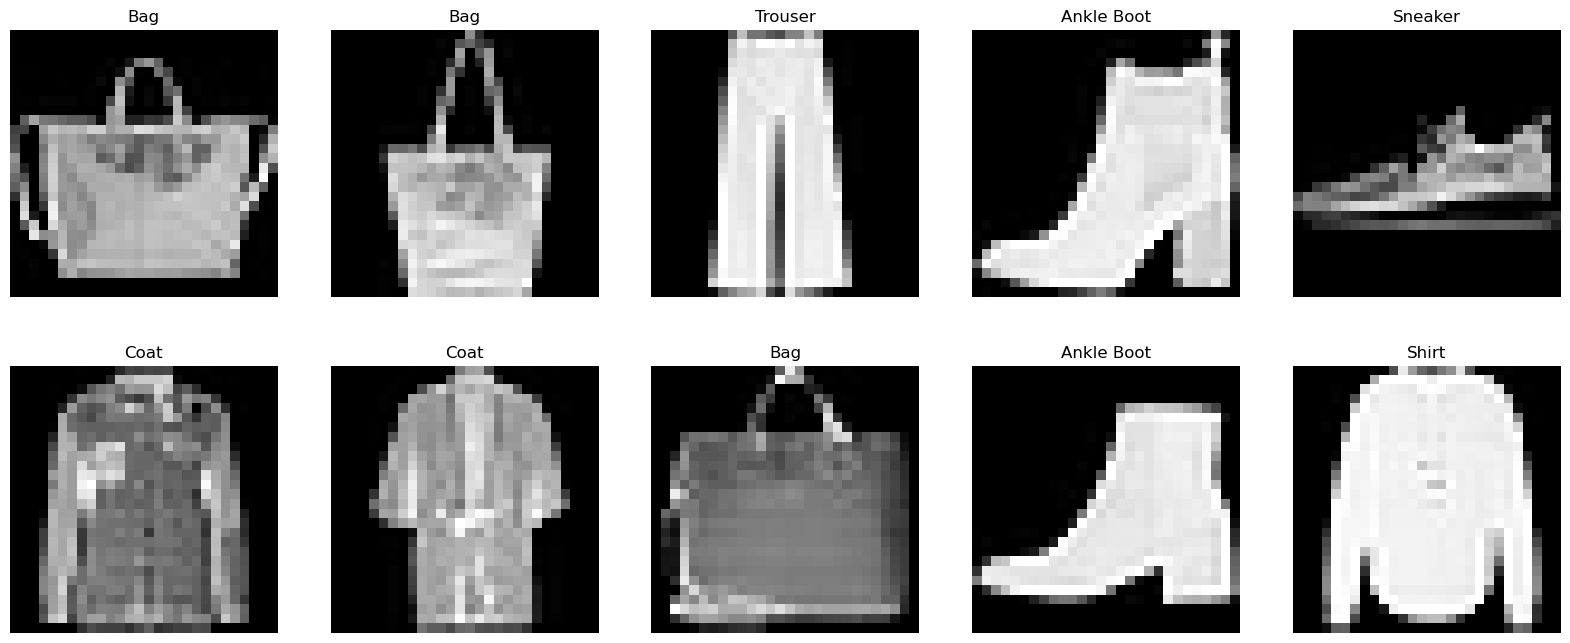

In [11]:
figure = plt.figure(figsize = (20, 8))
cols, rows = 5, 2

for i in range(1, cols * rows +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    print(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()


# `Step 3` : Set Network Structure

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        output = self.classifier(x)
        return output

# `Step 4` : Create Model instacne

In [14]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

# Model test

In [15]:
X = torch.rand(1, 28, 28, device=device)
output = model(X)
print(f'모델 출력 결과: {output}\n')
pred_probab = nn.Softmax(dim=1)(output)
print(f'Softmax 결과: {pred_probab}\n')
y_pred = pred_probab.argmax()
print(y_pred)

모델 출력 결과: tensor([[ 0.2122, -0.0533,  0.4609, -0.1348, -0.2897,  0.0426,  0.2330, -0.0539,
         -0.2371,  0.3135]], device='cuda:0', grad_fn=<AddmmBackward0>)

Softmax 결과: tensor([[0.1144, 0.0878, 0.1468, 0.0809, 0.0693, 0.0966, 0.1169, 0.0877, 0.0730,
         0.1267]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

tensor(2, device='cuda:0')

# `Step 5` : Model compile

In [16]:
# Loss
loss = nn.CrossEntropyLoss()
# Optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# `Step 6` : Set train loop

In [1]:
def train_loop(train_loader, model, loss_fn, optimizer):
    size = len(train_loader.dataset)

    for batch, (X,y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)

        # loss calculation
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:7>f} [{current:>5d}]/{size:5d}')

# `Step 7` : Set test loop

In [21]:
def test_loop(test_loader, model, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:8f}\n')

# `Step 8` : Run model

In [22]:
epochs = 10

for i in range(epochs):
    print(f'Epoch {i+1} \n--------------------------')
    train_loop(train_dataloader, model, loss, optimizer)
    test_loop(test_dataloader, model, loss)
print("Done")

Epoch 1 
--------------------------
loss: 0.431373 [    0]/60000
loss: 0.587412 [ 6400]/60000
loss: 0.583656 [12800]/60000
loss: 0.526607 [19200]/60000
loss: 0.425904 [25600]/60000
loss: 0.559104 [32000]/60000
loss: 0.255318 [38400]/60000
loss: 0.401609 [44800]/60000
loss: 0.359597 [51200]/60000
loss: 0.415519 [57600]/60000
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.441000

Epoch 2 
--------------------------
loss: 0.396597 [    0]/60000
loss: 0.282736 [ 6400]/60000
loss: 0.348952 [12800]/60000
loss: 0.394269 [19200]/60000
loss: 0.309174 [25600]/60000
loss: 0.406731 [32000]/60000
loss: 0.255115 [38400]/60000
loss: 0.464652 [44800]/60000
loss: 0.266001 [51200]/60000
loss: 0.316354 [57600]/60000
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.396377

Epoch 3 
--------------------------
loss: 0.343163 [    0]/60000
loss: 0.417957 [ 6400]/60000
loss: 0.361057 [12800]/60000
loss: 0.290214 [19200]/60000
loss: 0.439867 [25600]/60000
loss: 0.573623 [32000]/60000
loss: 0.358405 [38400]/60000
loss: 0

# `Step 9` : Save & load model

### **parameter만 저장하고 불러오기**

In [23]:
torch.save(model.state_dict(), 'model_weights.pth')

In [24]:
model2 = NeuralNetwork().to(device)
print(model2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [25]:
model2.load_state_dict(torch.load('model_weights.pth'))

In [26]:
model2.eval()
test_loop(test_dataloader, model2, loss)

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.334797


# Model 전체를 저장하고 불러오기

In [27]:
torch.save(model, 'model.pth')

In [28]:
model3 = torch.load('model.pth')

In [29]:
model3.eval()
test_loop(test_dataloader, model3, loss)

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.334797
